# NLP Movie Genre Classification - Random Forest Classifier

by Andrew Alarcon

## Introduction

In the previous two notebooks, I created Logistic Regression models to predict the genre's of movies/shows and then tried to optimize the models. Here, I will be using the Random Forest Classifier to perform the same prediction, and measure its performance against the Logistic Regression models.

## Loading in the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


import nltk
import re
import time

#from sklearn import svm

## Loading in the Data

In [40]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')

y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')


In [50]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (40744, 281)
X_test shape: (10187, 281)
y_train shape: (40744, 1)
y_test shape: (10187, 1)


In [54]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [55]:
# Turning 1-D column vector into an 1-D array
y_train = y_train.ravel()
y_test = y_test.ravel()

In [86]:
#Scaled data not needed for Decision Trees or Random Forests. Using original data.
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [6]:
# Poor performance
tree_model.score(X_test, y_test)

0.3354275056444488

Using the default parameters of a Decision Tree Classifier, the performance turns out to be very poor. It's accuracy is not much better than my Dummy Classifier from Notebook 3.1, where the accuracy was 25%.

I will now try to improve this performance by using a Bagging Classifier.

In [7]:
# Ensemble of DT
from sklearn.ensemble import BaggingClassifier
ensemble_of_DT = BaggingClassifier(DecisionTreeClassifier(),
                                   n_estimators=30,
                                   random_state=1) #n_estimators?
ensemble_of_DT.fit(X_train, y_train)

ensemble_of_DT.score(X_test, y_test)

/Users/andrewalarcon/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.45067242564052223

Okay, I somewhat of an improvement here. However, the score is still lower from the Logistic Regression performance by around 5%.

## Random Forest Model

Moving onto Random Forests, I want to find a good range for `n_estimators`, `min_samples_leaf,` and `max_depth` to have ready for grid search.

Here, I will run a series of Random Forest models with different values of n for the estimators.

In [27]:
cv_scores = []

for n in range(1,111,20):
    
    print(f'Working on the model with {n} estimators', end='\r')
    
    rfc = RandomForestClassifier(n_estimators = n)
    
    cv_score = np.mean(cross_val_score(rfc, X_train, y_train, cv = 5))
    
    cv_scores.append(cv_score)

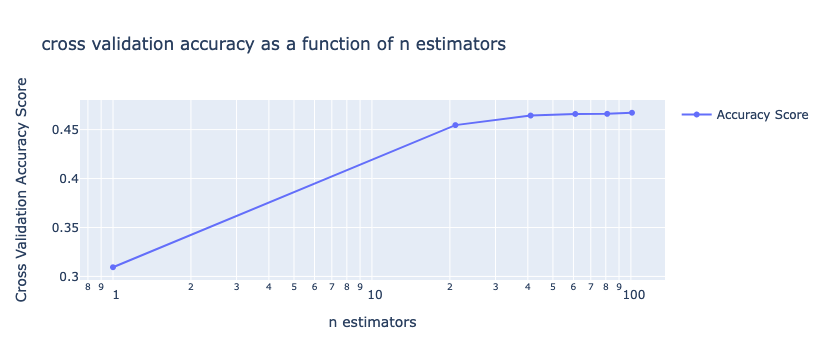

In [29]:
fig = px.line(title='cross validation accuracy as a function of n estimators', x=np.arange(1,111, 20) , y=cv_scores)

fig.update_traces(mode='markers+lines')

fig.update_xaxes(title_text="n estimators", type="log")
fig.update_yaxes(title_text="Cross Validation Accuracy Score")

fig.data[0].name="Accuracy Score"
#fig.data[1].name="Testing Scores"
fig.update_traces(mode='markers+lines', showlegend=True)

fig.show()

Looking at this chart, I'm going to pick a range of `n_estimators` from 60 to 100.

Now I will try to find the best ranges for `min_samples_leaf` and `max_depth`.

In [87]:
cv_scores = []

for n in range(1,31,5):
    
    print(f'Working on the model with min_sample_leaf = {n}', end='\r')
    
    rfc = RandomForestClassifier(min_samples_leaf=n)
    
    cv_score = np.mean(cross_val_score(rfc, X_train, y_train, cv = 5))
    
    cv_scores.append(cv_score)

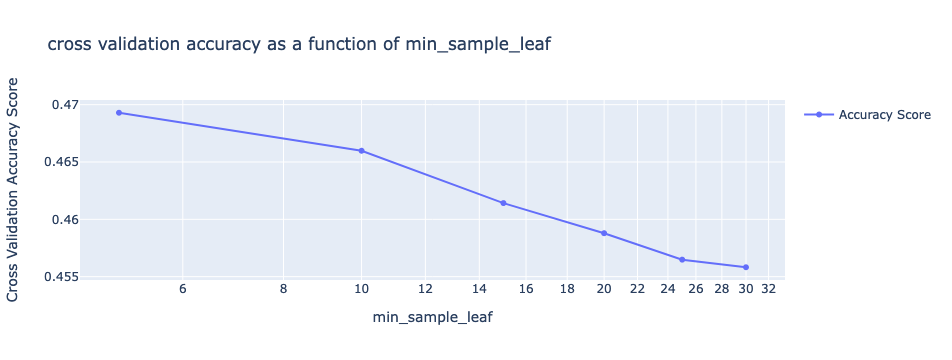

In [88]:
fig = px.line(title='cross validation accuracy as a function of min_sample_leaf', x=np.arange(5,31,5) , y=cv_scores)

fig.update_traces(mode='markers+lines')

fig.update_xaxes(title_text="min_sample_leaf", type="log")
fig.update_yaxes(title_text="Cross Validation Accuracy Score")

fig.data[0].name="Accuracy Score"
#fig.data[1].name="Testing Scores"
fig.update_traces(mode='markers+lines', showlegend=True)

fig.show()

Here it looks like keeping `min_samples_leaf` to 1 is the best choice.

In [74]:
cv_scores = []

for n in range(30,110,10):
    
    print(f'Working on the model with max_depth = {n}', end='\r')
    
    rfc = RandomForestClassifier(max_depth=n)
    
    cv_score = np.mean(cross_val_score(rfc, X_train, y_train, cv = 5))
    
    cv_scores.append(cv_score)
#takes about 30 minutes    

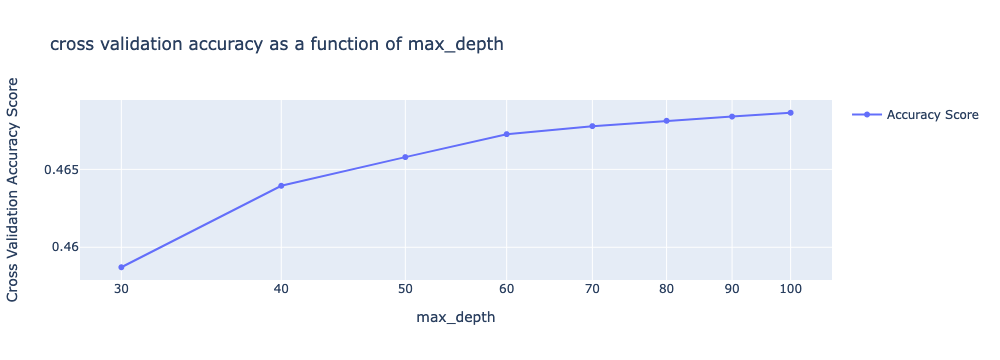

In [76]:
fig = px.line(title='cross validation accuracy as a function of max_depth', x=np.arange(30,110,10), y=cv_scores)

fig.update_traces(mode='markers+lines')

fig.update_xaxes(title_text="max_depth", type="log")
fig.update_yaxes(title_text="Cross Validation Accuracy Score")

fig.data[0].name="Accuracy Score"
#fig.data[1].name="Testing Scores"
fig.update_traces(mode='markers+lines', showlegend=True)

fig.show()

It looks like a good range between 70 and 100 would be good for `max_depth`.

In [81]:
# Grid Search 
estimators = [('scaler', StandardScaler()),
              ('rf', RandomForestClassifier())]

pipe = Pipeline(estimators)


param_grid = [
    {
              'rf': [RandomForestClassifier()],
              'rf__n_estimators': np.arange(60, 111, 20),
              'rf__max_depth': range(70, 105, 5),
              'rf__random_state': [42]
    }
]

# Instantiating the cross-validation grid search object with the param_grid
grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose=5
)

fit_grid = grid.fit(X_train, y_train)
#Takes about 40 minutes

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END rf=RandomForestClassifier(), rf__max_depth=70, rf__n_estimators=60, rf__random_state=42; total time=  15.7s
[CV 2/5] END rf=RandomForestClassifier(), rf__max_depth=70, rf__n_estimators=60, rf__random_state=42; total time=  14.4s
[CV 3/5] END rf=RandomForestClassifier(), rf__max_depth=70, rf__n_estimators=60, rf__random_state=42; total time=  13.7s
[CV 4/5] END rf=RandomForestClassifier(), rf__max_depth=70, rf__n_estimators=60, rf__random_state=42; total time=  14.0s
[CV 5/5] END rf=RandomForestClassifier(), rf__max_depth=70, rf__n_estimators=60, rf__random_state=42; total time=  13.7s
[CV 1/5] END rf=RandomForestClassifier(), rf__max_depth=70, rf__n_estimators=80, rf__random_state=42; total time=  17.5s
[CV 2/5] END rf=RandomForestClassifier(), rf__max_depth=70, rf__n_estimators=80, rf__random_state=42; total time=  17.9s
[CV 3/5] END rf=RandomForestClassifier(), rf__max_depth=70, rf__n_estimators=80, rf__random

In [82]:
fit_grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(max_depth=100, random_state=42))])

In [83]:
fit_grid.best_params_

{'rf': RandomForestClassifier(max_depth=100, random_state=42),
 'rf__max_depth': 100,
 'rf__n_estimators': 100,
 'rf__random_state': 42}

In [84]:
rfc_model = fit_grid.best_estimator_.steps[1][1] #taking the individual steps, then the second elmnt of the tuple
rfc_model

RandomForestClassifier(max_depth=100, random_state=42)

From the grid search, we can see that the best Random Forest Classifier has a `max_depth=18`, `n_estimators=100`. Let's measure this model's performance.

In [85]:
# Instantiate
rf_model = RandomForestClassifier(max_depth=18, n_estimators=100, random_state=42)

# Fit
rf_model.fit(X_train, y_train) #scaling not necessary for random forest

# Evaluate
print('Training Score:', rf_model.score(X_train, y_train))
print('Testing Score:', rf_model.score(X_test, y_test))

Training Score: 0.4852248183781661
Testing Score: 0.4415431432217532


Lookin at this model's accuracy, both of the training and testing accuracies are much lower than the best performing Logistic Regression model. The Random Forest Classifier scored 48.5% on training and 44.2% on testing, while the best performing Logistic Regression scored at 51.5% on training and 49.9% on testing.

In [89]:
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      action       0.00      0.00      0.00       238
   adventure       0.00      0.00      0.00       134
   animation       0.00      0.00      0.00        96
   biography       0.00      0.00      0.00        57
      comedy       0.68      0.14      0.24      1458
       crime       0.00      0.00      0.00        79
 documentary       0.48      0.86      0.62      2595
       drama       0.39      0.81      0.52      2465
      family       0.00      0.00      0.00       136
     fantasy       0.00      0.00      0.00        47
   game show       0.00      0.00      0.00        36
     history       0.00      0.00      0.00        46
      horror       0.00      0.00      0.00       407
       music       0.00      0.00      0.00       149
     musical       0.00      0.00      0.00        58
     mystery       0.00      0.00      0.00        54
        news       0.00      0.00      0.00        28
  reality tv       0.00    

/Users/andrewalarcon/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/andrewalarcon/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/andrewalarcon/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



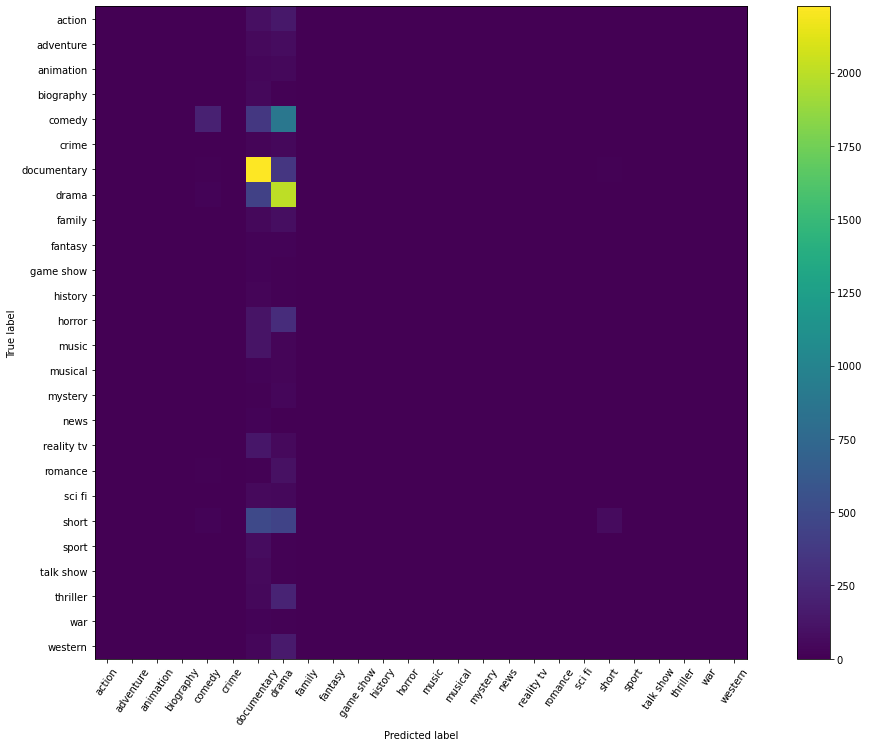

In [91]:
fig, ax = plt.subplots(figsize=(18, 12))
plot_confusion_matrix(rf_model, X_test, y_test, cmap='viridis', ax=ax, xticks_rotation=55, include_values=False);


What's very interesting in this confusion matrix is that the model predicted many movies to be drama when they were actually other genres, like `short`, `horror`, and mostly `comedy`. There is also some overlap between `documentary` and `drama`, where the model mistakes one for the other. This makes sense considering these two genre's take up much of the dataset. As for the rest of the confusion matrix, the model performs quite poorly because of the lack of data for the rest of the genres that aren't within the top 5 most frequently appearing genres.

## Conclusion

In this notebook, I built a Random Forest Classifier with hyperparameters chosen by Grid Search given a range a values I passed through it. After measuring the performance, I noticed that the accuracy was not performing as well as the Logistic Regression Model's I made in the previous two notebooks. As for the Precision, it seemed to be scoring much less to the Precision in the previous models, however, the Recall was scoring better. However, the improvement in Recall was less impactful than the decrease in Precision, resulting in a lower F1 score.

In the next and final notebook, I will be re-creating the best perfoming model and pickle it so that it would be ready for production.